In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
batch_size = 32
lr = 3e-4
num_epochs = 20

In [44]:
import requests, os
from tqdm import tqdm

In [45]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz"
save_path = './imagenette2.tgz'

if not os.path.exists(save_path):
    response = requests.get(dataset_url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in tqdm(response.iter_content(chunk_size=1024)):
            if chunk:
                file.write(chunk)

In [46]:
import tarfile
extract_path = './imagenette2'
with tarfile.open(save_path, 'r:gz') as tar:
    tar.extractall(extract_path)

In [47]:
from torchvision.datasets import ImageFolder

In [48]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [49]:
train_dataset = ImageFolder(root=os.path.join(extract_path, 'imagenette2/train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder(root=os.path.join(extract_path, 'imagenette2/val'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

image_batch, label_batch = next(iter(train_loader))
image, label = image_batch[0], label_batch[0]

In [50]:
len(train_dataset)

9469

In [51]:
classes = train_dataset.classes

In [52]:
class_names = {
    'n01440764': 'tench',
    'n02102040': 'English springer',
    'n02979186': 'cassette player',
    'n03000684': 'chain saw',
    'n03028079': 'church',
    'n03394916': 'French horn',
    'n03417042': 'garbage truck',
    'n03425413': 'gas pump',
    'n03445777': 'golf ball',
    'n03888257': 'parachute'
}


In [53]:
image.shape

torch.Size([3, 224, 224])

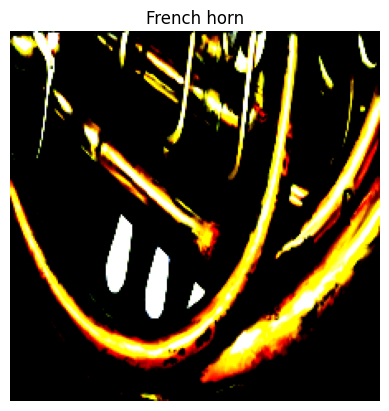

In [54]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[classes[int(label)]])
plt.axis('off');

In [55]:
image_permutted = image.permute(1, 2, 0)

In [56]:
import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

warnings.resetwarnings()

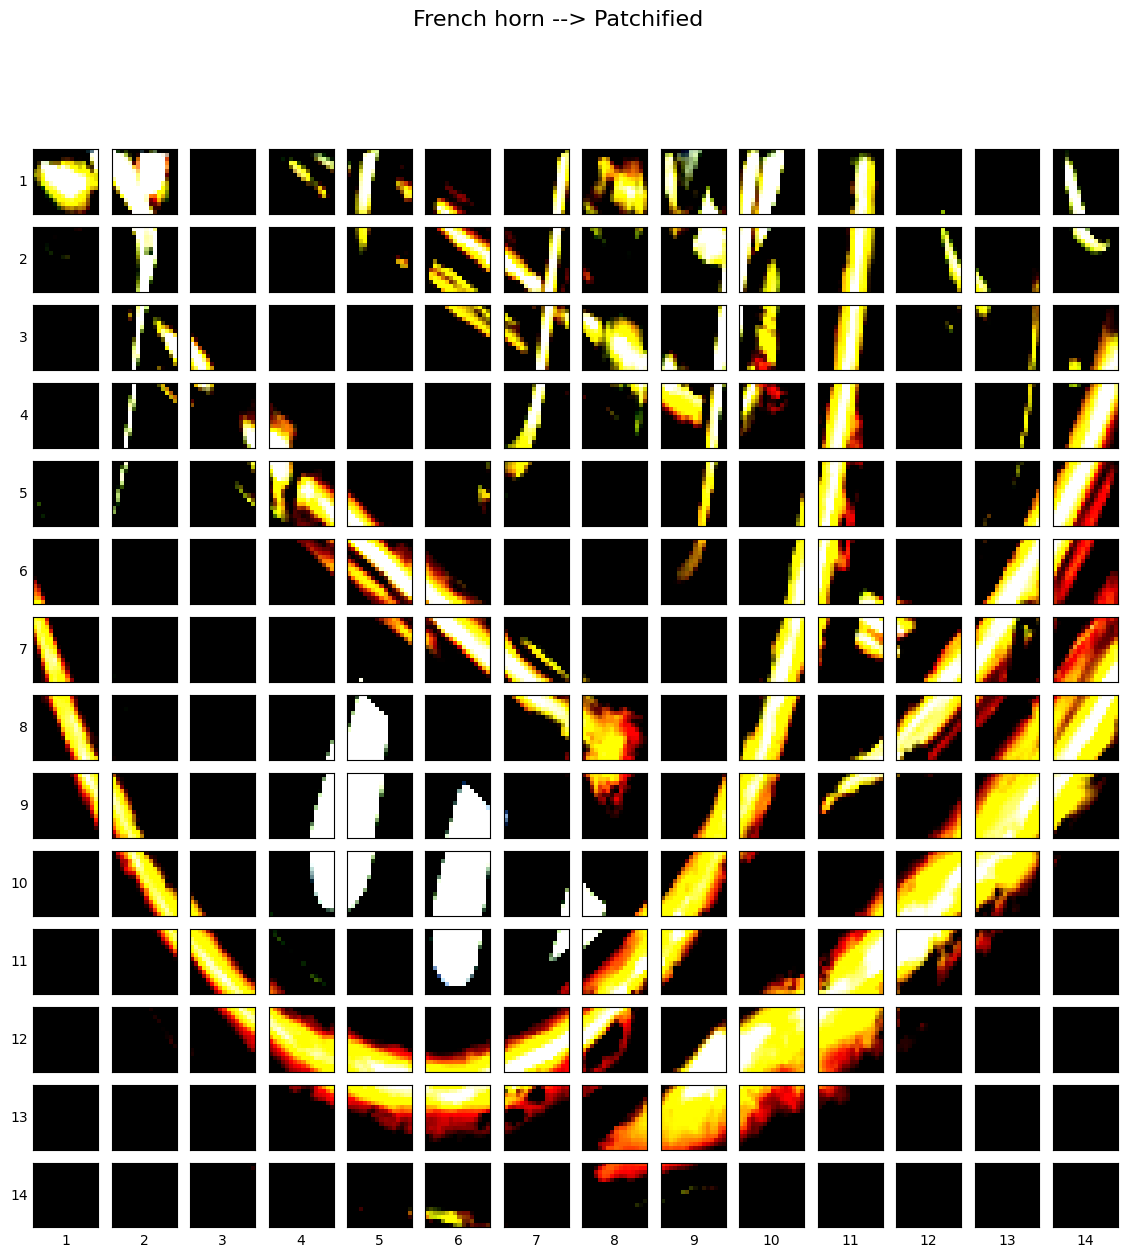

In [57]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'

fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, figsize=(num_patches, num_patches), sharex=True, sharey=True);

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permutted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :]);
        axs[i, j].set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center');
        axs[i, j].set_xlabel(j+1);
        axs[i, j].set_xticks([]);
        axs[i, j].set_yticks([]);
        axs[i, j].label_outer();

fig.suptitle(f"{class_names[classes[int(label)]]} --> Patchified", fontsize=16);
plt.show();

In [58]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, 'Input image size must be divisble by patch size'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [59]:
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
print(f'Inupt image shape: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Patched image shape: {patch_embedded_image.shape} --> (batch_size, num_of_patches, embedding_dim)')

Inupt image shape: torch.Size([1, 3, 224, 224])
Patched image shape: torch.Size([1, 196, 768]) --> (batch_size, num_of_patches, embedding_dim)


In [60]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(class_token[:, :, :10])
print(f'Class Token shape: {class_token.shape} --> (batch_size, num_of_tokens, embedding_dim)')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class Token shape: torch.Size([1, 1, 768]) --> (batch_size, num_of_tokens, embedding_dim)


In [61]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(patch_embedded_image_with_class_embedding)
print(f'{patch_embedded_image_with_class_embedding.shape=} --> (batch_size, num_of_patches, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5086,  0.1887,  1.0870,  ...,  0.6740,  0.7288, -1.4947],
         [-0.3016, -0.5381, -0.3566,  ...,  0.3233,  1.0423, -1.3980],
         ...,
         [ 0.2284,  0.7357,  1.7337,  ...,  1.2958, -0.7318, -0.7727],
         [ 0.2284,  0.7357,  1.7337,  ...,  1.2958, -0.7318, -0.7727],
         [ 0.2284,  0.7357,  1.7337,  ...,  1.2958, -0.7318, -0.7727]]],
       grad_fn=<CatBackward0>)
patch_embedded_image_with_class_embedding.shape=torch.Size([1, 197, 768]) --> (batch_size, num_of_patches, embedding_dim)


In [62]:
num_of_patches = int((224 * 224) / patch_size**2)
embedding_dimesion = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1, num_of_patches+1, embedding_dimension), requires_grad=True)
print(position_embedding[:, :10, :10])
print(f'{position_embedding.shape=} --> (batch_size, num_of_patches, embedding_dim)')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
position_embedding.shape=torch.Size([1, 197, 768]) --> (batch_size, num_of_patches, embedding_dim)


In [63]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f'{patch_and_position_embedding.shape}')

torch.Size([1, 197, 768])


In [64]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [65]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: ', {patch_and_position_embedding.shape})
print(f'Output shape of MSA block: ', {patched_image_through_msa_block.shape})

Input shape of MSA block:  {torch.Size([1, 197, 768])}
Output shape of MSA block:  {torch.Size([1, 197, 768])}


In [66]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [67]:
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: ', patched_image_through_msa_block.shape)
print(f'Output shape of MLP block: ', patched_image_through_mlp_block.shape)

Input shape of MLP block:  torch.Size([1, 197, 768])
Output shape of MLP block:  torch.Size([1, 197, 768])


In [68]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attn_dropout=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=attn_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [69]:
transformer_encoder_block = TransformerEncoderBlock()

In [70]:
class ViT(nn.Module):
    def __init__(self, img_size=224, in_channels=3, batch_size=16, num_transformer_layer=12, embedding_dim=768, mlp_size=3072, num_heads=12, attn_dropout=0, mlp_dropout=0.1, embedding_dropout=0.1, num_classes=10):
        super().__init__()
        assert img_size % patch_size == 0, 'Image size must be divisible by patch size'

        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [71]:
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[ 0.3032, -0.1830,  0.6783,  0.3717,  0.3674, -0.1311,  0.7035,  0.1042,
          0.1466, -0.2869]], grad_fn=<AddmmBackward0>)

In [72]:
!pip install -q torchinfo

In [73]:
from torchinfo import summary

summary(model=vit, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 10]             152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [74]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = nn.CrossEntropyLoss()

In [75]:
def train_step(model, dataloader, loss_fn, optimizer, device=device):
    model.to(device)
    model.train()
    train_loss, train_acc = 0., 0.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [76]:
def test_step(model, dataloader, loss_fn, device=device):
    model.to(device)
    model.eval()
    test_loss, test_acc = 0., 0.
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [77]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device=device):
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; device

'cuda'

In [79]:
results = train(model=vit, train_dataloader=train_loader, test_dataloader=test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=10)

 10%|█         | 1/10 [07:49<1:10:29, 470.00s/it]

Epoch: 0 | Train Loss: 2.3413 | Train Acc: 0.1217 | Test Loss: 2.3127 | Test Acc: 0.0907


 20%|██        | 2/10 [15:43<1:02:56, 472.04s/it]

Epoch: 1 | Train Loss: 2.3213 | Train Acc: 0.1002 | Test Loss: 2.3095 | Test Acc: 0.0907


 30%|███       | 3/10 [23:25<54:31, 467.39s/it]  

Epoch: 2 | Train Loss: 2.3172 | Train Acc: 0.1024 | Test Loss: 2.3108 | Test Acc: 0.0983


 40%|████      | 4/10 [30:51<45:53, 458.86s/it]

Epoch: 3 | Train Loss: 2.3158 | Train Acc: 0.0981 | Test Loss: 2.3152 | Test Acc: 0.0981


 50%|█████     | 5/10 [38:10<37:39, 451.89s/it]

Epoch: 4 | Train Loss: 2.3122 | Train Acc: 0.0972 | Test Loss: 2.3093 | Test Acc: 0.1065


 60%|██████    | 6/10 [45:29<29:49, 447.39s/it]

Epoch: 5 | Train Loss: 2.3098 | Train Acc: 0.0991 | Test Loss: 2.3085 | Test Acc: 0.1001


 70%|███████   | 7/10 [52:24<21:50, 436.91s/it]

Epoch: 6 | Train Loss: 2.3084 | Train Acc: 0.0997 | Test Loss: 2.3071 | Test Acc: 0.1004


 80%|████████  | 8/10 [59:08<14:12, 426.46s/it]

Epoch: 7 | Train Loss: 2.3087 | Train Acc: 0.1002 | Test Loss: 2.3057 | Test Acc: 0.1019


 90%|█████████ | 9/10 [1:05:51<06:59, 419.20s/it]

Epoch: 8 | Train Loss: 2.3051 | Train Acc: 0.1019 | Test Loss: 2.3141 | Test Acc: 0.0988


100%|██████████| 10/10 [1:12:37<00:00, 435.74s/it]

Epoch: 9 | Train Loss: 2.3047 | Train Acc: 0.1056 | Test Loss: 2.3062 | Test Acc: 0.1004


In [80]:
def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_acc')
    plt.plot(epochs, test_accuracy, label='test_acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


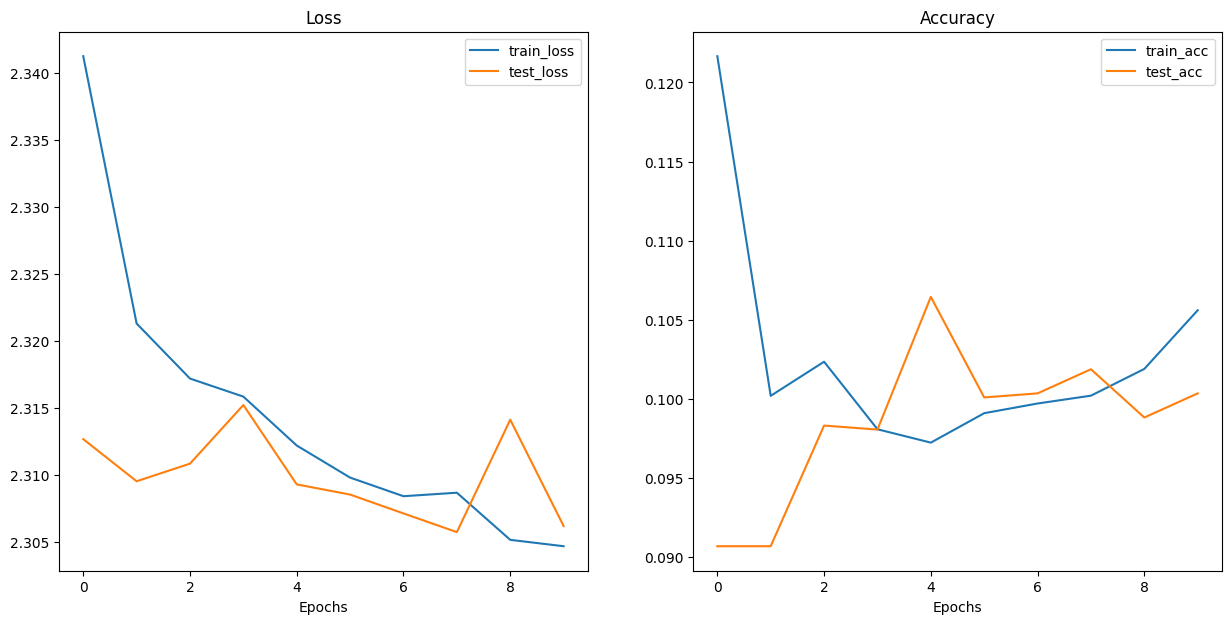

In [81]:
plot_loss_curves(results)

In [82]:
def make_preds(model, data, device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
import random
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample image label: {test_labels[0]} ({class_names[classes[int(test_labels[0])]]})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test sample image shape: torch.Size([3, 224, 224])
Test sample image label: 3 (chain saw)


In [84]:
pred_probs = make_preds(model=vit, data=test_samples)
pred_probs[:2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[0.0931, 0.1110, 0.1052, 0.0878, 0.0924, 0.1002, 0.1079, 0.1088, 0.1047,
         0.0888],
        [0.0931, 0.1110, 0.1052, 0.0878, 0.0924, 0.1002, 0.1079, 0.1088, 0.1047,
         0.0888]])

In [85]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [87]:
test_labels, pred_classes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([3, 9, 8, 3, 7, 0, 5, 3, 3], tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]))

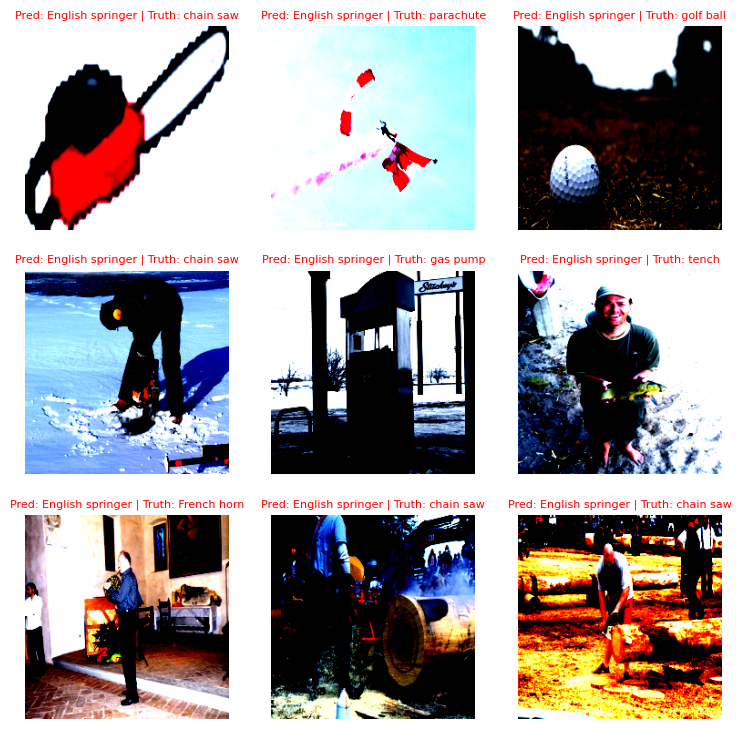

In [92]:
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1);
    plt.imshow(sample.permute(1, 2, 0))
    pred_label = class_names[classes[int(pred_classes[i])]]
    truth_label = class_names[classes[int(test_labels[i])]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c='g')
    else:
        plt.title(title_text, fontsize=8, c='r')
    plt.axis(False);

In [93]:
import random
train_samples = []
train_labels = []

for sample, label in random.sample(list(train_dataset), k=9):
    train_samples.append(sample)
    train_labels.append(label)

print(f"Test sample image shape: {train_samples[0].shape}\nTest sample image label: {train_labels[0]} ({class_names[classes[int(train_labels[0])]]})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test sample image shape: torch.Size([3, 224, 224])
Test sample image label: 2 (cassette player)


In [94]:
train_pred_probs = make_preds(model=vit, data=train_samples)
train_pred_classes = train_pred_probs.argmax(dim=1)
train_pred_classes

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [95]:
train_labels, train_pred_classes

([2, 1, 7, 3, 7, 3, 8, 9, 0], tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]))

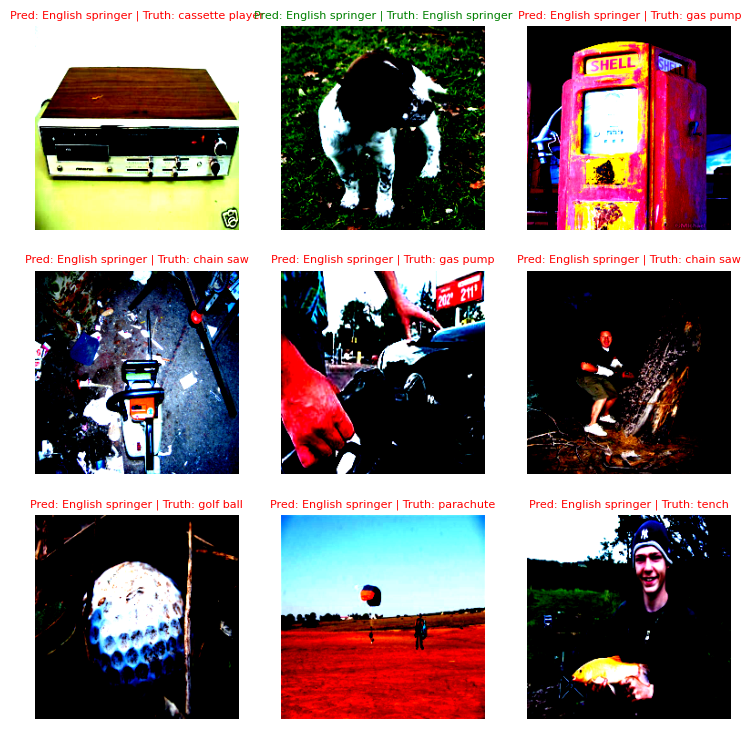

In [96]:
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3

for i, sample in enumerate(train_samples):
    plt.subplot(nrows, ncols, i+1);
    plt.imshow(sample.permute(1, 2, 0))
    pred_label = class_names[classes[int(pred_classes[i])]]
    truth_label = class_names[classes[int(train_labels[i])]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c='g')
    else:
        plt.title(title_text, fontsize=8, c='r')
    plt.axis(False);